<a href="https://colab.research.google.com/github/yajuna/tmath307/blob/master/2nd_order_DE_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we explore using tensorflow to solve second order differential equations.

The example problem we use is

$t^2y''+3ty'+4y=t$

together with initial conditions

$y(1) = 0, y'(1)=1$,

solved on the interval [1,3]

We solve it in two ways:

1. Solve the DE as a second order problem.

2. Solve the DE as a system of 2 order 1 differential equations.

We use the physics-informed neural network (PINN) methodology in both problems.

In [81]:
# import numpy and Tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# Set date type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

EPOCH = 5000

# set constant- need to be tensors
e = tf.constant([np.e], dtype = DTYPE)

# initial condition at t_0 = 1
t_0 = tf.constant([1], dtype = DTYPE)

# y_0 = 0, and yt_0 = 1 at t_0 = 1.
y_0 = tf.constant([0.], dtype=DTYPE)
yt_0 = tf.constant([1.], dtype=DTYPE)

# number of points in time, time interval is [1, 3]
N_0 = 50
time_interval = [1., 3.] #

# convert constants to tensor; need [] outside of time_interval[j] to work correctly
tmin = tf.constant([time_interval[0]], dtype=DTYPE)
tmax = tf.constant([time_interval[1]], dtype=DTYPE)

Define residual of the differential equation

$ r = t^2y_{tt} + 3ty_t+4y-t$

In [83]:
# solve second order DE
# define the residual

def residual(t, y, y_t, y_tt):
  return t**2 * y_tt + 3 * t * y_t + 4 * y - t

### Define time variables- function $y$ is evaluated at these $t$ values.

In [84]:
# t is assigned randomly
# t = tf.random.uniform((N_0,1), tmin, tmax, dtype=DTYPE)

# t is assigned use linear space
t = tf.linspace(tmin, tmax, N_0)

Set up model.

This is a sequential model, set up by adding layers one by one.

The variable t is first scaled to be from `[tmin, tmax]` to `[0,1]`. This is to help the activation function.

The model has 8 hidden layer, with 20 neurons each. The input is 1 dimensional, and takes time; the output is 1 dimensional, and outputs the function  $y(t)$.

In [85]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is one-dimensional (time)
    model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input [tmin, tmax] to [-1, 1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda t: 2.0*(t - tmin)/(tmax - tmin) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

## Compute physics informed residual, loss and gradients.

In [86]:
def get_residual(model, t):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:

        # Variables t is watched during tape
        # to compute derivatives y_t
        tape.watch(t)

        # compute y and y_t within the tape, as we still need y_t to compute y_tt
        y = model(t)
        y_t = tape.gradient(y, t)

    y_tt = tape.gradient(y_t, t)
    del tape
    # Determine residual
    return residual(t, y, y_t, y_tt)

In [87]:
def compute_loss(model, t, t_0, y_0, yt_0):

    # Compute mean square of residual for non initial values
    r = get_residual(model, t)
    non_ic_r = tf.reduce_mean(tf.square(r))

    # first part of loss
    loss = non_ic_r

    with tf.GradientTape(persistent=True) as tape:

        # Variables t is watched during tape
        # to compute derivatives y_t
        tape.watch(t_0)

        # compute y within the tape, as we still need y to compute y_t
        # Add loss at initial condition

        y_pred = model(t_0)


    yt_pred = tape.gradient(y_pred, t_0)

    del tape
    loss += tf.reduce_mean(tf.square(y_0 - y_pred))
    loss += tf.reduce_mean(tf.square(yt_0 - yt_pred))

    return loss

In [88]:
model = init_model()
loss = compute_loss(model, t, t_0, y_0, yt_0)

In [89]:
def get_grad_of_loss(model, t, t_0, y_0, yt_0):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, t, t_0, y_0, yt_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

Set up optimizer and train model.

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model. Notice the learning rate decreases as the training goes on.

In [90]:
# Initialize model aka y_\theta
model = init_model(num_hidden_layers=2)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for  𝑁=5000  epochs. Here, we set up a function `train_step()` which performs one training step.

Note: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [91]:
from time import time

# add function wrapper to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad_of_loss(model, t, t_0, y_0, yt_0)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = EPOCH
hist = []

# Start timer
t0 = time()

for i in range(N + 1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%500 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.88914967e+00
It 00500: loss = 1.36156770e-04
It 01000: loss = 3.57403005e-05
It 01500: loss = 3.42678832e-05
It 02000: loss = 3.25554392e-05
It 02500: loss = 3.06361690e-05
It 03000: loss = 2.85854785e-05
It 03500: loss = 2.74668764e-05
It 04000: loss = 2.62143603e-05
It 04500: loss = 2.48519755e-05
It 05000: loss = 2.33961964e-05

Computation time: 9.374922513961792 seconds


In the following, we plot the computational solution and the analytical solution. The analytical solution is

$y(t) = (3t^2 + 5\sqrt{3}\sin(\sqrt{3}\ln(t))-3\cos(\sqrt{3}\ln(t)))/21t $


and was given [here](https://www.wolframalpha.com/input?i=t%5E2y%27%27+%2B+3ty%27%2B4y+%3D+t%2C+y%281%29+%3D+0%2C+y%27%281%29%3D1)



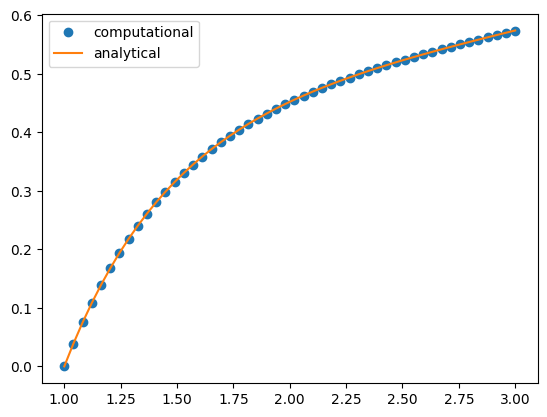

In [92]:
y = model(t).numpy().reshape(len(t))

tt = tf.linspace(tmin, tmax, N_0)

numerator = 3. * tt**2 + 5. * np.sqrt(3.) * np.sin(np.sqrt(3.) * np.log(tt))  - 3. * np.cos(np.sqrt(3.) * np.log(tt))

gold = numerator / (21 * tt)

fig, ax = plt.subplots()
ax.plot(t, y, 'o', label = 'computational')
ax.plot(tt, gold, label = 'analytical')
ax.legend()

plt.show()

# In the next part, we formulate the second order DE to be a system of two first order DEs.

Let $Y(t) = \begin{pmatrix}y\\ y'\end{pmatrix}$,  

then the original equation can be written as the system

$\begin{pmatrix}y'\\ y''\end{pmatrix} = Y'(t) = \begin{pmatrix}0&1\\ -4/t^2 & -3/t\end{pmatrix}Y + \begin{pmatrix}0\\ 1/t\end{pmatrix}$,

with the initial condition $Y(1) = \begin{pmatrix}0\\ 1\end{pmatrix}$

We use the PINN methodology by minimizing the residual

$r = Y'(t) - \begin{pmatrix}0&1\\ -4/t^2 & -3/t\end{pmatrix}Y - \begin{pmatrix}0\\ 1/t\end{pmatrix}$



In [93]:
# initial conditions

Y_0 = tf.constant([0., 1.], dtype=DTYPE)

In [94]:
# vector residual

def vector_residual(t, Y, Y_t):
  A = tf.Variable([0,1,-4/t**2,-3/t], shape = [2,2])
  rhs = tf.Variable([0, 1/t], shape = [2,1])
  return Y_t - tf.matmul(A, Y) - rhs

In [95]:
# vetor model

def init_vector_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    vector_model = tf.keras.Sequential()

    # Input is one-dimensional (time)
    vector_model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input [tmin, tmax] to [-1, 1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda t: 2.0*(t - tmin)/(tmax - tmin) - 1.0)
    vector_model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        vector_model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    vector_model.add(tf.keras.layers.Dense(1))

    return vector_model

In [96]:
def get_vector_residual(vector_model, t):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:

        # Variables t is watched during tape
        # to compute derivatives y_t
        tape.watch(t)

        # compute y and y_t within the tape, as we still need y_t to compute y_tt
        Y = vector_model(t)
    Y_t = tape.gradient(Y, t)


    del tape
    # Determine residual
    return vector_residual(t, Y, Y_t)

In [97]:
def compute_vector_loss(vector_model, t, t_0, Y_0):

    # Compute mean square of residual for non initial values
    r_vector = get_vector_residual(vector_model, t)
    non_ic_r_vector = tf.reduce_mean(tf.square(r_vector))

    loss_vector = non_ic_r_vector
    Y0_pred = vector_model(t_0)


    loss_vector += tf.reduce_mean(tf.square(Y_0 - Y0_pred))

    return loss_vector

In [98]:
vector_model = init_vector_model()
r_vector = get_vector_residual(vector_model, t)


# loss_vector = compute_vector_loss(vector_model, t, t_0, Y_0)

InvalidArgumentError: ignored